In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [20]:
#A simple neural network architecture
class genetic_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.architecture= nn.Sequential(
        nn.Linear(7,16),
        nn.ReLU(),
        nn.Linear(16,5),
    
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-3.0, b=3.0)   
    def forward(self,x):
        logits = self.architecture(x)
        return logits
#A function to get the weights of the nn
def gene(network):
    flat_params = torch.cat([p.view(-1) for p in network.parameters()])
    return flat_params

def set_gene(gene):
    model = genetic_network()
    pointer = 0
    for param in model.parameters():
        numel = param.numel()
        new_values = gene[pointer:pointer+numel].view_as(param)
        with torch.no_grad():
            param.copy_(new_values)
        pointer+=numel
    return model


In [21]:
price_modifier = 1
start_money = 1
#Farmer class
class Farmer:
    def __init__(self):
        self.food = 0
        self.clothes = 0
        self.luxury = 0
        self.money = start_money
        self.incoming_money = 0
        self.score = 0
        self.mind = genetic_network()
    def happiness(self):
        happy = 0 
        if(self.food>=1):
            happy += 10 + (self.food-1)*0.1
            self.food-=1
        else:
            happy =10*(1-self.food)
        if(self.clothes>=1):
            happy += 5 + (self.clothes-1)*0.2
            self.clothes-=1
        else:
            happy = 5*(1-self.clothes)
        if(self.luxury>0):
            happy += self.luxury*0.3
        self.score += happy 
    
    def think(self,taxF,taxT,taxB):
        inp = torch.tensor([taxF,taxT,taxB,self.food,self.clothes,self.luxury,self.money],dtype=torch.float32)
        self.decision = self.mind(inp)
        budget= self.decision[-4:]
        budget = F.softmax(budget,dim=0)*self.money
        self.decision = torch.cat([self.decision[:-4], budget])
        self.decision[0] = F.sigmoid(self.decision[0])*price_modifier
    
    def produce(self,skill):
        self.food += skill
#Tailor class
class Tailor:
    def __init__(self):
        self.food = 0
        self.clothes = 0
        self.luxury = 0
        self.money = start_money
        self.incoming_money = 0
        self.mind = genetic_network()
        self.score = 0
    def happiness(self):
        happy = 0 
        if(self.food>=1):
            happy += 10 + (self.food-1)*0.1
            self.food-=1
        else:
            happy =10*(1-self.food)
        if(self.clothes>=1):
            happy += 5 + (self.clothes-1)*0.2
            self.clothes-=1
        else:
            happy = 5*(1-self.clothes)
        if(self.luxury>0):
            happy += self.luxury*0.3
        self.score += happy 

    def think(self,taxF,taxT,taxB):
        inp = torch.tensor([taxF,taxT,taxB,self.food,self.clothes,self.luxury,self.money],dtype=torch.float32)
        self.decision = self.mind(inp)
        budget= self.decision[-4:]
        budget = F.softmax(budget,dim=0)*self.money
        self.decision = torch.cat([self.decision[:-4], budget])
        self.decision[0] = F.sigmoid(self.decision[0])*price_modifier
    
    def produce(self,skill):
        self.clothes += skill
#Business
class Business:
    def __init__(self):
        self.food = 0
        self.clothes = 0
        self.luxury = 0
        self.money = start_money
        self.incoming_money = 0
        self.score = 0
        self.mind = genetic_network()
    def happiness(self):
        happy = 0 
        if(self.food>=1):
            happy += 10 + (self.food-1)*0.1
            self.food-=1
        else:
            happy =10*(1-self.food)
        if(self.clothes>=1):
            happy += 5 + (self.clothes-1)*0.2
            self.clothes-=1
        else:
            happy = 5*(1-self.clothes)
        if(self.luxury>0):
            happy += self.luxury*0.3
        self.score += happy 
    def think(self,taxF,taxT,taxB):
        inp = torch.tensor([taxF,taxT,taxB,self.food,self.clothes,self.luxury,self.money],dtype=torch.float32)
        self.decision = self.mind(inp)
        budget= self.decision[-4:]
        budget = F.softmax(budget,dim=0)*self.money

        self.decision = torch.cat([self.decision[:-4], budget])
        self.decision[0] = F.sigmoid(self.decision[0])*price_modifier
    
    def produce(self,skill):
        self.luxury += skill


In [22]:
#Redistributing food
best_farmer = []
def simulate(farmers:list,tailors:list,businesses:list,taxF,taxT,taxB):
    fm = 0 
    cm = 0
    lm =0 
    
    for f in farmers:
        f.produce(5)
        f.think(taxF,taxT,taxB)
        fm += float(f.decision[1])
        cm += float(f.decision[2])
        lm += float(f.decision[3])
        f.money -= f.decision[1]+f.decision[2]+f.decision[3]
    for t in tailors:
        t.produce(3)
        t.think(taxF,taxT,taxB)
        fm += float(t.decision[1])
        cm += float(t.decision[2])
        lm += float(t.decision[3])
        t.money -= t.decision[1]+t.decision[2]+t.decision[3]
    for b in businesses:
        b.produce(1)
        b.think(taxF,taxT,taxB)
        fm += float(b.decision[1])
        cm += float(b.decision[2])
        lm += float(b.decision[3])
        b.money -= b.decision[1]+b.decision[2]+b.decision[3]

    farmers = sorted(farmers,key=lambda b:b.decision[0])
    tailors = sorted(tailors,key=lambda b:b.decision[0])
    businesses= sorted(businesses,key=lambda b:b.decision[0])
    
    fm_total = fm
    cm_total = cm
    lm_total = lm

    food_bought = 0
    clothes_bought = 0
    luxuries_bought = 0

    #Check how many clothes can be bought
    for i in range(0,len(farmers)):
        total_cost = float(farmers[i].decision[0]*farmers[i].food)
        if(fm<total_cost):
            fb = (fm/total_cost)*farmers[i].food
            food_bought += fb
            farmers[i].food -= fb
            farmers[i].money += fm
            fm = 0
        else:
            food_bought += farmers[i].food
            farmers[i].food = 0
            farmers[i].money += total_cost
            fm -= total_cost
    #Check how many clothes can be bought
    for i in range(0,len(tailors)):
        total_cost = float(tailors[i].decision[0]*tailors[i].clothes)
        if(cm<total_cost):
            cb = (cm/total_cost)*tailors[i].clothes
            clothes_bought += cb
            tailors[i].clothes -= cb
            tailors[i].money+=cm
            cm = 0
        else:
            clothes_bought += tailors[i].clothes
            tailors[i].clothes = 0
            tailors[i].money += total_cost
            cm -= total_cost
    
    for i in range(0,len(businesses)):
        total_cost = float(businesses[i].decision[0]*businesses[i].luxury)
        if(lm<total_cost):
            lb = (lm/total_cost)*businesses[i].luxury
            luxuries_bought += lb
            businesses[i].luxury -= lb
            businesses[i].money += lm
            lm = 0
        else:
            luxuries_bought += float(businesses[i].luxury)
            businesses[i].luxury = 0
            businesses[i].money+= total_cost
            lm -= total_cost

    #Redistribute items and leftover money
    f_score = []
    t_score = []
    b_score = []
    
    for f in farmers:
        f.food += float((f.decision[1]/fm_total)*food_bought)
        f.clothes += float((f.decision[2]/cm_total)*clothes_bought)
        f.luxury += float((f.decision[3]/lm_total)*luxuries_bought)
        f.money += float((f.decision[1]/fm_total)*fm + (f.decision[2]/cm_total)*cm + (f.decision[3]/lm_total)*lm)
        f.happiness()
        f_score.append(f.score)
    for t in tailors:
        t.food += float((t.decision[1]/fm_total)*food_bought)
        t.clothes += float((t.decision[2]/cm_total)*clothes_bought)
        t.luxury += float((t.decision[3]/lm_total)*luxuries_bought)
        t.money += float((t.decision[1]/fm_total)*fm + (t.decision[2]/cm_total)*cm + (t.decision[3]/lm_total)*lm)
        t.happiness()
        t_score.append(t.score)
    for b in businesses:
        b.food += float((b.decision[1]/fm_total)*food_bought)
        b.clothes += float((b.decision[2]/cm_total)*clothes_bought)
        b.luxury += float((b.decision[3]/lm_total)*luxuries_bought)
        b.money += float((b.decision[1]/fm_total)*fm + (b.decision[2]/cm_total)*cm + (b.decision[3]/lm_total)*lm)
        b.happiness()
        b_score.append(b.score)
    
farmers = []
tailors = []
businesses = []

for i in range(0,100):
    farmers.append(Farmer())
    tailors.append(Tailor())
    businesses.append(Business())

for i in range(0,10):
    simulate(farmers,tailors,businesses,0,0,0)

In [23]:
#Do some metrices for everyone
print("BEST Farmer ",max(f.score for f in farmers))
print("BEST Trader ",max(t.score for t in tailors))
print("BEST business ",max(b.score for b in businesses))
print("WORST Farmer ",min(f.score for f in farmers))
print("WORST Trader ",min(t.score for t in tailors))
print("WORST business ",min(b.score for b in businesses))


BEST Farmer  238.76473429396614
BEST Trader  233.07786540199658
BEST business  361.2320469388647
WORST Farmer  47.2536771719918
WORST Trader  49.47514292705857
WORST business  9.268129497230984


In [24]:
#Recombination strategies
def recombine_weighted(gene_a,gene_b,alpha):
    return (gene_a*alpha + (1-alpha)*gene_b,gene_b*alpha + (1-alpha)*gene_a)

#def 1 point crossover
def crossover(gene_a,gene_b):
    m = int(len(gene_a) / 2)
    child1 = torch.cat([gene_a[:m], gene_b[m:]], dim=0)
    child2 = torch.cat([gene_b[:m], gene_a[m:]], dim=0)
    return child1, child2


In [25]:
#Formula for generating next generation
def generate(farmers,tailors,businesses):
    farmers = sorted(farmers,key=lambda b:b.score,reverse=True)
    tailors = sorted(tailors,key=lambda t:t.score,reverse=True)
    businesses = sorted(businesses,key=lambda b:b.score,reverse=True)
    
    new_farmers = []
    new_tailors = []
    new_businesses = []
    #Add the top 30%performers to the next set of farmers
    for i in range(0,int(0.3*len(farmers))):
        f = Farmer()
        f.mind = farmers[i].mind
        new_farmers.append(f)

    #Add some recombinations
    while len(new_farmers)<len(farmers):
        chosen_one = random.choices(farmers, weights=[f.score for f in farmers], k=1)[0]
        remaining = [f for f in farmers if f != chosen_one]
        remaining_weights = [f.score for f in remaining]
        chosen_two = random.choices(remaining, weights=remaining_weights, k=1)[0]
        gene_a = gene(chosen_one.mind)
        gene_b = gene(chosen_two.mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        f = Farmer()
        f.mind = set_gene(mutated[0])
        new_farmers.append(f) 
        f2 = Farmer()
        f2.mind = set_gene(mutated[1])
        new_farmers.append(f2)
        f = Farmer()
        f.mind = set_gene(mutated2[0])
        new_farmers.append(f) 
        f2 = Farmer()
        f2.mind = set_gene(mutated2[1])
        new_farmers.append(f2)
    #Add the top 30%performers to the next set of tailors
    for i in range(0,int(0.3*len(tailors))):
        t = Tailor()
        t.mind = tailors[i].mind
        new_tailors.append(t)

    #Add some recombinations
    while len(new_tailors)<len(tailors):
        chosen_many = random.choices(farmers,weights=[t.score for t in tailors],k=2)
        gene_a = gene(chosen_many[0].mind)
        gene_b = gene(chosen_many[1].mind)
        mutated = crossover(gene_a,gene_b)
        mutated = recombine_weighted(gene_a,gene_b,0.4)
        t = Tailor()
        t.mind = set_gene(mutated[0])
        new_tailors.append(t) 
        t2 = Tailor()
        t2.mind = set_gene(mutated[1])
        new_tailors.append(t2)
        t = Tailor()
        t.mind = set_gene(mutated2[0])
        new_tailors.append(t) 
        t2 = Tailor()
        t2.mind = set_gene(mutated2[1])
        new_tailors.append(t2)
    #Add the top 30%performers to the next set of businesses
    for i in range(0,int(0.3*len(businesses))):
        b = Business()
        b.mind = businesses[i].mind
        new_businesses.append(b)

    #Add some recombinations
    while len(new_businesses)<len(businesses):
        chosen_many = random.choices(businesses,weights=[b.score for b in businesses],k=2)
        gene_a = gene(chosen_many[0].mind)
        gene_b = gene(chosen_many[1].mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        b = Business()
        b.mind = set_gene(mutated[0])
        new_businesses.append(b) 
        b2 = Business()
        b2.mind = set_gene(mutated[1])
        new_businesses.append(b2)
        b = Business()
        b.mind = set_gene(mutated2[0])
        new_businesses.append(b) 
        b2 = Business()
        b2.mind = set_gene(mutated2[1])
        new_businesses.append(b2)
    
    return new_farmers,new_tailors,new_businesses

In [26]:
#Start the actual simulation
avg_farmer = []
avg_tailor = []
avg_business = []
avg_total = []
best_farmer = []
best_tailor = []
best_business = []

farmers = []
tailors = []
businesses = []

for i in range(0,100):
    farmers.append(Farmer())
    tailors.append(Tailor())
    businesses.append(Business())

for i in range(0,100):
    for j in range(0,10):
        simulate(farmers,tailors,businesses,0,0,0)
    avg_farmer.append(sum([f.score for f in farmers])/len(farmers))
    avg_tailor.append(sum([t.score for t in tailors])/len(tailors))
    avg_business.append(sum([b.score for b in businesses])/len(businesses))
    avg_total.append((sum([b.score for b in businesses])+sum([t.score for t in tailors])+sum([f.score for f in farmers]))/(len(farmers)+len(tailors)+len(businesses)))
    best_farmer.append(max([f.score for f in farmers]))
    best_tailor.append(max([t.score for t in tailors]))
    best_business.append(max([b.score for b in businesses]))
    farmers,tailors,businesses = generate(farmers,tailors,businesses)

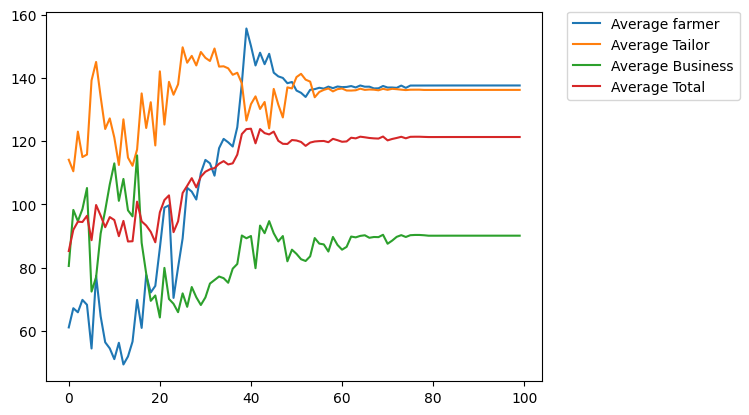

In [27]:
import matplotlib.pyplot as plt

plt.plot(avg_farmer,label="Average farmer")
plt.plot(avg_tailor,label="Average Tailor")
plt.plot(avg_business,label="Average Business")
plt.plot(avg_total,label="Average Total")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


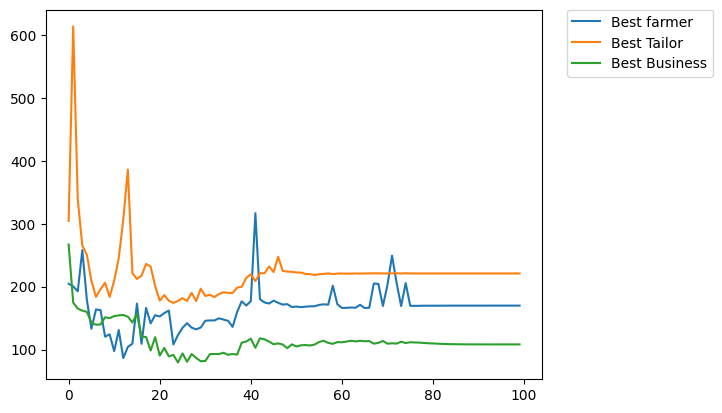

In [28]:

plt.plot(best_farmer,label="Best farmer")
plt.plot(best_tailor,label="Best Tailor")
plt.plot(best_business,label="Best Business")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
